# py-rsample Demo: Time Series Resampling

This notebook demonstrates the time series resampling capabilities of py-rsample, including:
- Simple train/test splits with `initial_time_split()`
- Cross-validation with `time_series_cv()`
- Rolling vs expanding windows
- Forecast horizons (lag) and period parsing
- Integration with py-parsnip for model evaluation

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Import py-rsample functions
from py_rsample import initial_time_split, time_series_cv

# Import py-parsnip for model fitting
from py_parsnip import linear_reg

np.random.seed(42)

## 1. Create Sample Time Series Data

Let's create a synthetic time series with trend and seasonality.

In [21]:
# Create 3 years of daily data
dates = pd.date_range(start="2020-01-01", end="2022-12-31", freq="D")
n = len(dates)

# Generate time series with trend + seasonality + noise
t = np.arange(n)
trend = 100 + 0.05 * t
seasonality = 20 * np.sin(2 * np.pi * t / 365.25)  # Annual seasonality
noise = np.random.normal(0, 5, n)

data = pd.DataFrame({
    "date": dates,
    "sales": trend + seasonality + noise,
    "day_of_year": dates.dayofyear,
    "month": dates.month,
    "year": dates.year - 2020,  # Years since 2020
})

print(f"Dataset: {len(data)} days from {data['date'].min()} to {data['date'].max()}")
print(f"\nFirst few rows:")
data.head()

Dataset: 1096 days from 2020-01-01 00:00:00 to 2022-12-31 00:00:00

First few rows:


,date,sales,day_of_year,month,year
0,2020-01-01,102.483571,1,1,0
1,2020-01-02,99.702710,2,1,0
2,2020-01-03,104.026404,3,1,0
3,2020-01-04,108.796837,4,1,0
4,2020-01-05,100.404341,5,1,0


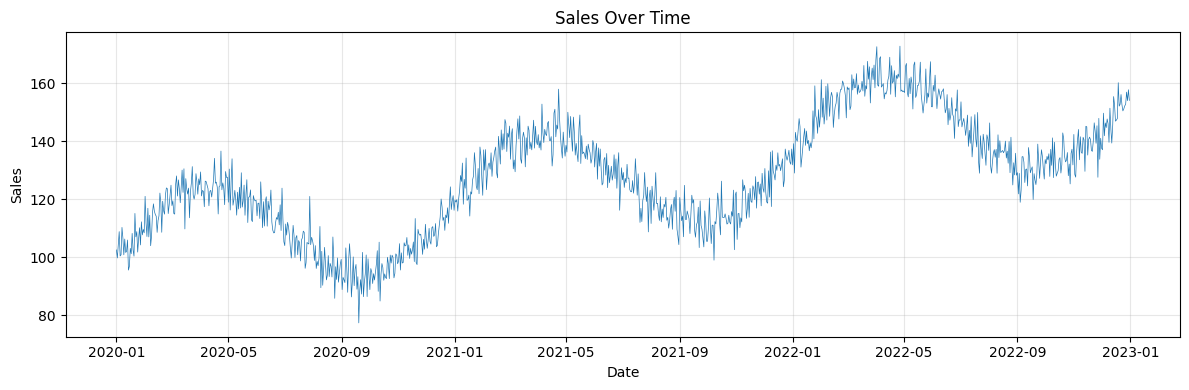

In [22]:
# Visualize the time series
plt.figure(figsize=(12, 4))
plt.plot(data["date"], data["sales"], linewidth=0.5)
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Simple Train/Test Split with `initial_time_split()`

The simplest approach is to split the data chronologically into training and testing sets.

### 2.1 Basic 75/25 Split

In [23]:
# Create a 75/25 split
split = initial_time_split(data, prop=0.75)

train = split.training()
test = split.testing()

print(f"Training set: {len(train)} days ({train['date'].min()} to {train['date'].max()})")
print(f"Testing set:  {len(test)} days ({test['date'].min()} to {test['date'].max()})")

Training set: 822 days (2020-01-01 00:00:00 to 2022-04-01 00:00:00)
Testing set:  274 days (2022-04-02 00:00:00 to 2022-12-31 00:00:00)


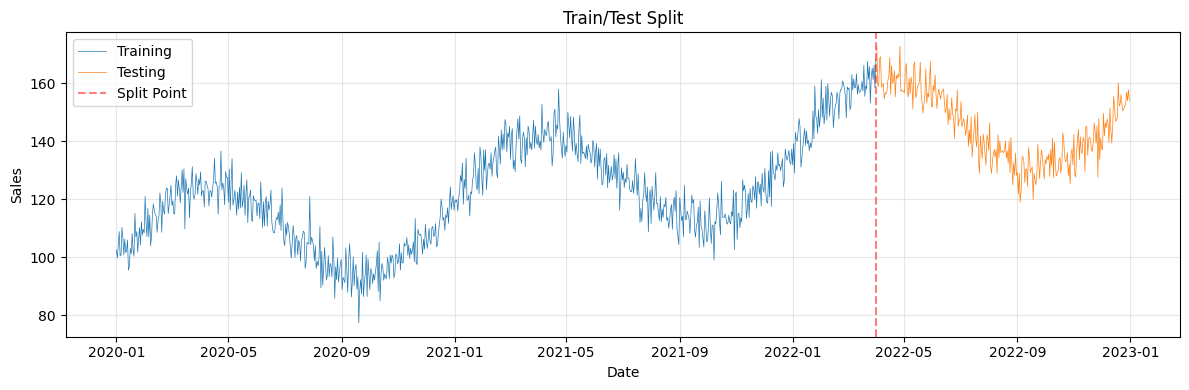

In [24]:
# Visualize the split
plt.figure(figsize=(12, 4))
plt.plot(train["date"], train["sales"], label="Training", linewidth=0.5)
plt.plot(test["date"], test["sales"], label="Testing", linewidth=0.5)
plt.axvline(train["date"].iloc[-1], color="red", linestyle="--", alpha=0.5, label="Split Point")
plt.title("Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2 Split with Forecast Horizon (Lag)

In practice, there's often a gap between when you train your model and when you need predictions.
For example, you might train on data up to today but need to forecast 7 days ahead.

In [25]:
# 75% train, but with a 30-day forecast horizon
split_lag = initial_time_split(data, prop=0.75, lag=30)

train_lag = split_lag.training()
test_lag = split_lag.testing()

print(f"Training set: {len(train_lag)} days ({train_lag['date'].min()} to {train_lag['date'].max()})")
print(f"Gap: 30 days")
print(f"Testing set:  {len(test_lag)} days ({test_lag['date'].min()} to {test_lag['date'].max()})")
print(f"\nNote: Testing set is smaller because of the 30-day gap")

Training set: 822 days (2020-01-01 00:00:00 to 2022-04-01 00:00:00)
Gap: 30 days
Testing set:  244 days (2022-05-02 00:00:00 to 2022-12-31 00:00:00)

Note: Testing set is smaller because of the 30-day gap


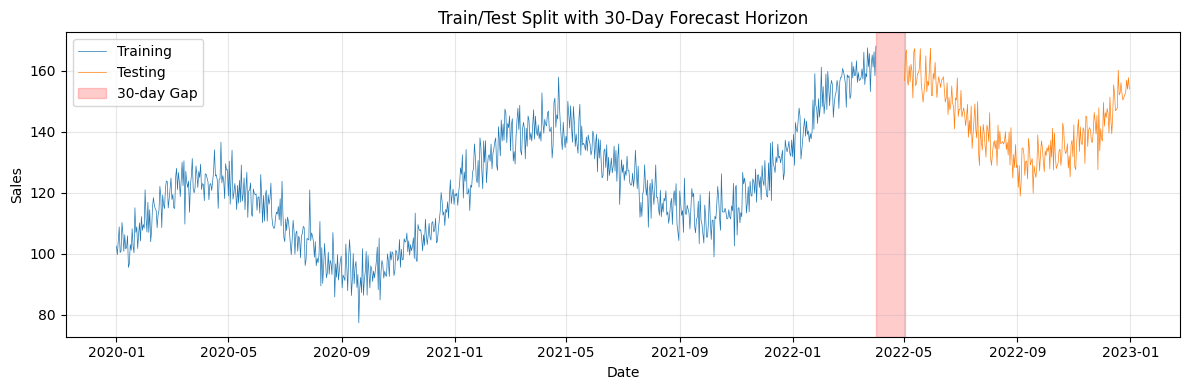

In [26]:
# Visualize the gap
plt.figure(figsize=(12, 4))
plt.plot(train_lag["date"], train_lag["sales"], label="Training", linewidth=0.5)
plt.plot(test_lag["date"], test_lag["sales"], label="Testing", linewidth=0.5)

# Shade the gap
gap_start = train_lag["date"].iloc[-1]
gap_end = test_lag["date"].iloc[0]
plt.axvspan(gap_start, gap_end, alpha=0.2, color="red", label="30-day Gap")

plt.title("Train/Test Split with 30-Day Forecast Horizon")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3 Using Period Strings

py-rsample supports human-readable period strings like "1 year", "3 months", "14 days".

In [27]:
# Train on first 2 years, test on remaining data with 1-week forecast horizon
split_period = initial_time_split(
    data,
    prop=2/3,  # Approximately 2 years out of 3
    lag="7 days",
    date_column="date"
)

train_period = split_period.training()
test_period = split_period.testing()

print(f"Training set: {len(train_period)} days ({train_period['date'].min()} to {train_period['date'].max()})")
print(f"Testing set:  {len(test_period)} days ({test_period['date'].min()} to {test_period['date'].max()})")

Training set: 730 days (2020-01-01 00:00:00 to 2021-12-30 00:00:00)
Testing set:  359 days (2022-01-07 00:00:00 to 2022-12-31 00:00:00)


### 2.4 Explicit Date Ranges (New!)

For more precise control, you can specify exact date ranges for training and testing sets.
This is useful when you need to:
- Train on specific historical periods
- Evaluate on precise holdout windows
- Handle irregular time periods or data gaps

#### Absolute Date Ranges

Specify exact start and end dates for train and test sets:

In [28]:
# Example: Train on 2020, test on first half of 2021
split_absolute = initial_time_split(
    data,
    date_column="date",
    train_start="2020-01-01",
    train_end="2020-12-31",
    test_start="2021-01-01",
    test_end="2021-06-30"
)

train_abs = split_absolute.training()
test_abs = split_absolute.testing()

print(f"Training: {len(train_abs)} days from {train_abs['date'].min()} to {train_abs['date'].max()}")
print(f"Testing:  {len(test_abs)} days from {test_abs['date'].min()} to {test_abs['date'].max()}")

Training: 822 days from 2020-01-01 00:00:00 to 2022-04-01 00:00:00
Testing:  274 days from 2022-04-02 00:00:00 to 2022-12-31 00:00:00


#### Relative Date Ranges

Use "start" and "end" keywords with relative offsets:

In [29]:
# Example 1: Train on first 18 months, test on last 6 months
split_relative1 = initial_time_split(
    data,
    date_column="date",
    train_start="start",
    train_end="start + 18 months",
    test_start="end - 6 months",
    test_end="end"
)

train_rel1 = split_relative1.training()
test_rel1 = split_relative1.testing()

print("Example 1: First 18 months vs last 6 months")
print(f"Training: {len(train_rel1)} days from {train_rel1['date'].min()} to {train_rel1['date'].max()}")
print(f"Testing:  {len(test_rel1)} days from {test_rel1['date'].min()} to {test_rel1['date'].max()}")
print()

# Example 2: Train on all but last 3 months, test on last 3 months (with 1-week gap)
split_relative2 = initial_time_split(
    data,
    date_column="date",
    train_start="start",
    train_end="end - 3 months - 7 days",
    test_start="end - 3 months",
    test_end="end"
)

train_rel2 = split_relative2.training()
test_rel2 = split_relative2.testing()

print("Example 2: All but last 3 months vs last 3 months (with 1-week gap)")
print(f"Training: {len(train_rel2)} days from {train_rel2['date'].min()} to {train_rel2['date'].max()}")
print(f"Testing:  {len(test_rel2)} days from {test_rel2['date'].min()} to {test_rel2['date'].max()}")

# Check the gap
gap_days = (test_rel2['date'].min() - train_rel2['date'].max()).days
print(f"Gap: {gap_days} days")

Example 1: First 18 months vs last 6 months
Training: 822 days from 2020-01-01 00:00:00 to 2022-04-01 00:00:00
Testing:  274 days from 2022-04-02 00:00:00 to 2022-12-31 00:00:00

Example 2: All but last 3 months vs last 3 months (with 1-week gap)
Training: 822 days from 2020-01-01 00:00:00 to 2022-04-01 00:00:00
Testing:  274 days from 2022-04-02 00:00:00 to 2022-12-31 00:00:00
Gap: 1 days


#### Mixed Absolute and Relative Dates

Combine absolute dates with relative offsets for maximum flexibility:

In [30]:
# Train on specific year (2020), test on last 3 months of available data
split_mixed = initial_time_split(
    data,
    date_column="date",
    train_start="2020-01-01",
    train_end="2020-12-31",
    test_start="end - 90 days",
    test_end="end"
)

train_mix = split_mixed.training()
test_mix = split_mixed.testing()

print("Mixed: Train on 2020, test on last 90 days of data")
print(f"Training: {len(train_mix)} days from {train_mix['date'].min()} to {train_mix['date'].max()}")
print(f"Testing:  {len(test_mix)} days from {test_mix['date'].min()} to {test_mix['date'].max()}")

Mixed: Train on 2020, test on last 90 days of data
Training: 822 days from 2020-01-01 00:00:00 to 2022-04-01 00:00:00
Testing:  274 days from 2022-04-02 00:00:00 to 2022-12-31 00:00:00


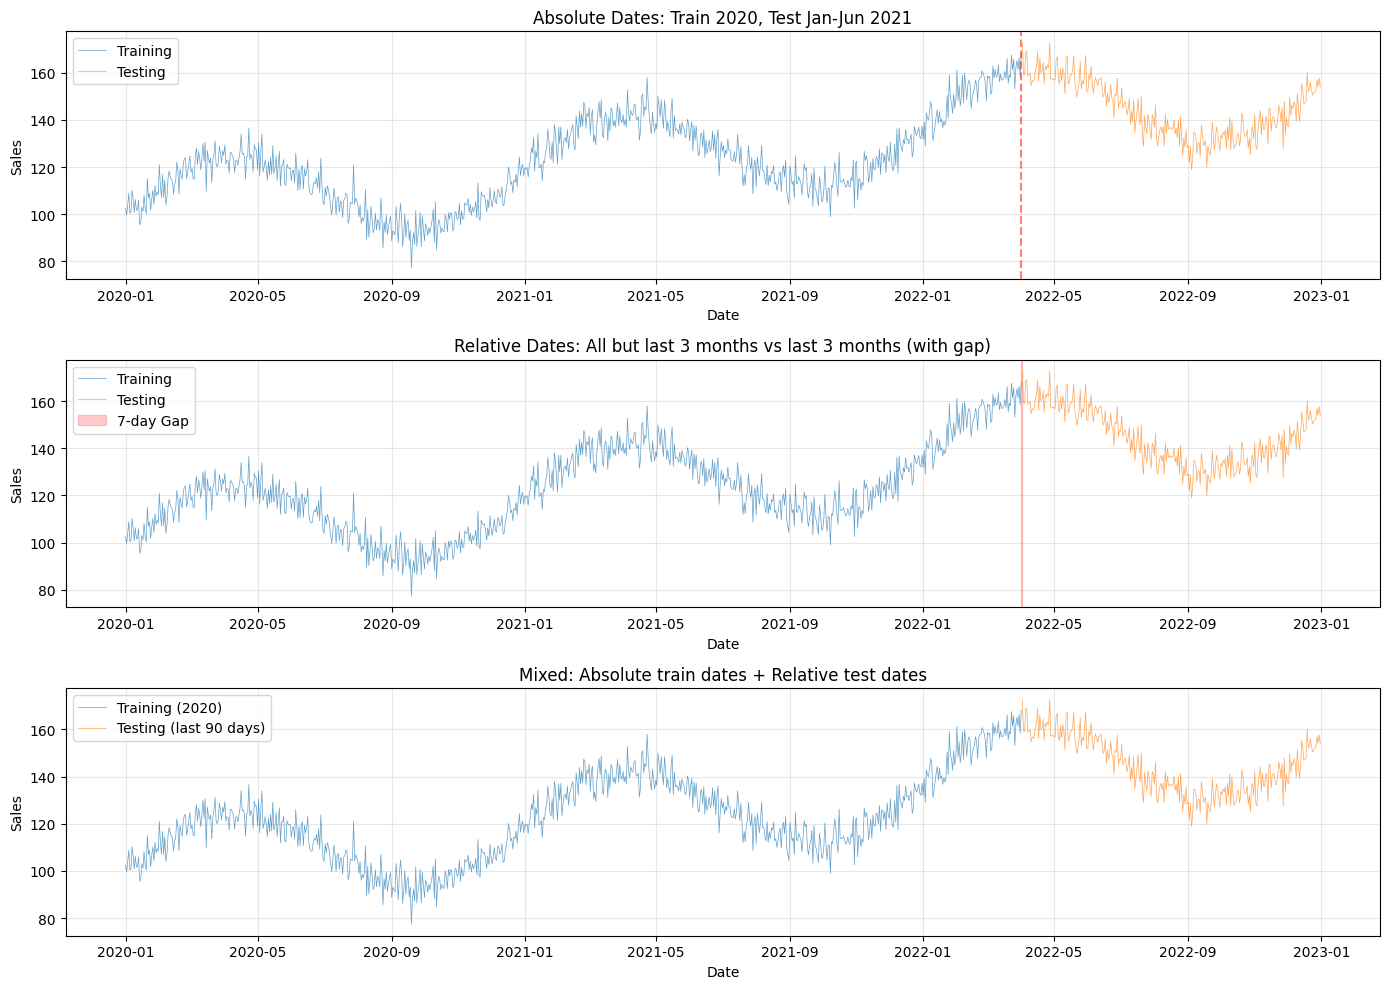

In [31]:
# Visualize different explicit date range approaches
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Absolute dates
ax = axes[0]
ax.plot(train_abs["date"], train_abs["sales"], label="Training", linewidth=0.5, alpha=0.7)
ax.plot(test_abs["date"], test_abs["sales"], label="Testing", linewidth=0.5, alpha=0.7)
ax.axvline(train_abs["date"].max(), color="red", linestyle="--", alpha=0.5)
ax.set_title("Absolute Dates: Train 2020, Test Jan-Jun 2021")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Relative dates
ax = axes[1]
ax.plot(train_rel2["date"], train_rel2["sales"], label="Training", linewidth=0.5, alpha=0.7)
ax.plot(test_rel2["date"], test_rel2["sales"], label="Testing", linewidth=0.5, alpha=0.7)
gap_start = train_rel2["date"].max()
gap_end = test_rel2["date"].min()
ax.axvspan(gap_start, gap_end, alpha=0.2, color="red", label="7-day Gap")
ax.set_title("Relative Dates: All but last 3 months vs last 3 months (with gap)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Mixed dates
ax = axes[2]
ax.plot(train_mix["date"], train_mix["sales"], label="Training (2020)", linewidth=0.5, alpha=0.7)
ax.plot(test_mix["date"], test_mix["sales"], label="Testing (last 90 days)", linewidth=0.5, alpha=0.7)
ax.set_title("Mixed: Absolute train dates + Relative test dates")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### When to Use Explicit Date Ranges

**Use explicit date ranges when you need:**
- **Precise control**: Train on specific historical periods (e.g., "all of 2020")
- **Non-overlapping holdout sets**: Ensure training and testing windows don't overlap in irregular datasets
- **Reproducibility**: Exact date specifications make your analysis more reproducible
- **Business logic**: Align splits with business cycles, seasons, or events
- **Walk-forward testing**: Create custom rolling windows with specific date boundaries

**Advantages over proportion-based splitting:**
- More intuitive for business stakeholders ("train on 2020-2021, test on Q1 2022")
- Handles irregular data or gaps better
- Easier to align with external events or business requirements
- More flexible for creating specific forecast scenarios

## 3. Time Series Cross-Validation

A single train/test split doesn't give a robust estimate of model performance.
Time series cross-validation creates multiple folds while respecting temporal ordering.

### 3.1 Expanding Window (Cumulative)

In an expanding window, the training set grows with each fold while the test set size stays constant.

In [32]:
# Create expanding window CV
cv_expanding = time_series_cv(
    data=data,
    date_column="date",
    initial="1 year",      # Start with 1 year of training data
    assess="3 months",     # Each test set is 3 months
    cumulative=True        # Expanding window
)

print(f"Number of CV folds: {len(cv_expanding)}")
print(f"\nFold sizes:")
for i, fold in enumerate(cv_expanding, 1):
    train_fold = fold.training()
    test_fold = fold.testing()
    print(f"Fold {i}: {len(train_fold):4d} train, {len(test_fold):3d} test | "
          f"Train: {train_fold['date'].min()} to {train_fold['date'].max()} | "
          f"Test: {test_fold['date'].min()} to {test_fold['date'].max()}")

Number of CV folds: 8

Fold sizes:
Fold 1:  365 train,  90 test | Train: 2020-01-01 00:00:00 to 2020-12-30 00:00:00 | Test: 2020-12-31 00:00:00 to 2021-03-30 00:00:00
Fold 2:  455 train,  90 test | Train: 2020-01-01 00:00:00 to 2021-03-30 00:00:00 | Test: 2021-03-31 00:00:00 to 2021-06-28 00:00:00
Fold 3:  545 train,  90 test | Train: 2020-01-01 00:00:00 to 2021-06-28 00:00:00 | Test: 2021-06-29 00:00:00 to 2021-09-26 00:00:00
Fold 4:  635 train,  90 test | Train: 2020-01-01 00:00:00 to 2021-09-26 00:00:00 | Test: 2021-09-27 00:00:00 to 2021-12-25 00:00:00
Fold 5:  725 train,  90 test | Train: 2020-01-01 00:00:00 to 2021-12-25 00:00:00 | Test: 2021-12-26 00:00:00 to 2022-03-25 00:00:00
Fold 6:  815 train,  90 test | Train: 2020-01-01 00:00:00 to 2022-03-25 00:00:00 | Test: 2022-03-26 00:00:00 to 2022-06-23 00:00:00
Fold 7:  905 train,  90 test | Train: 2020-01-01 00:00:00 to 2022-06-23 00:00:00 | Test: 2022-06-24 00:00:00 to 2022-09-21 00:00:00
Fold 8:  995 train,  90 test | Train: 202

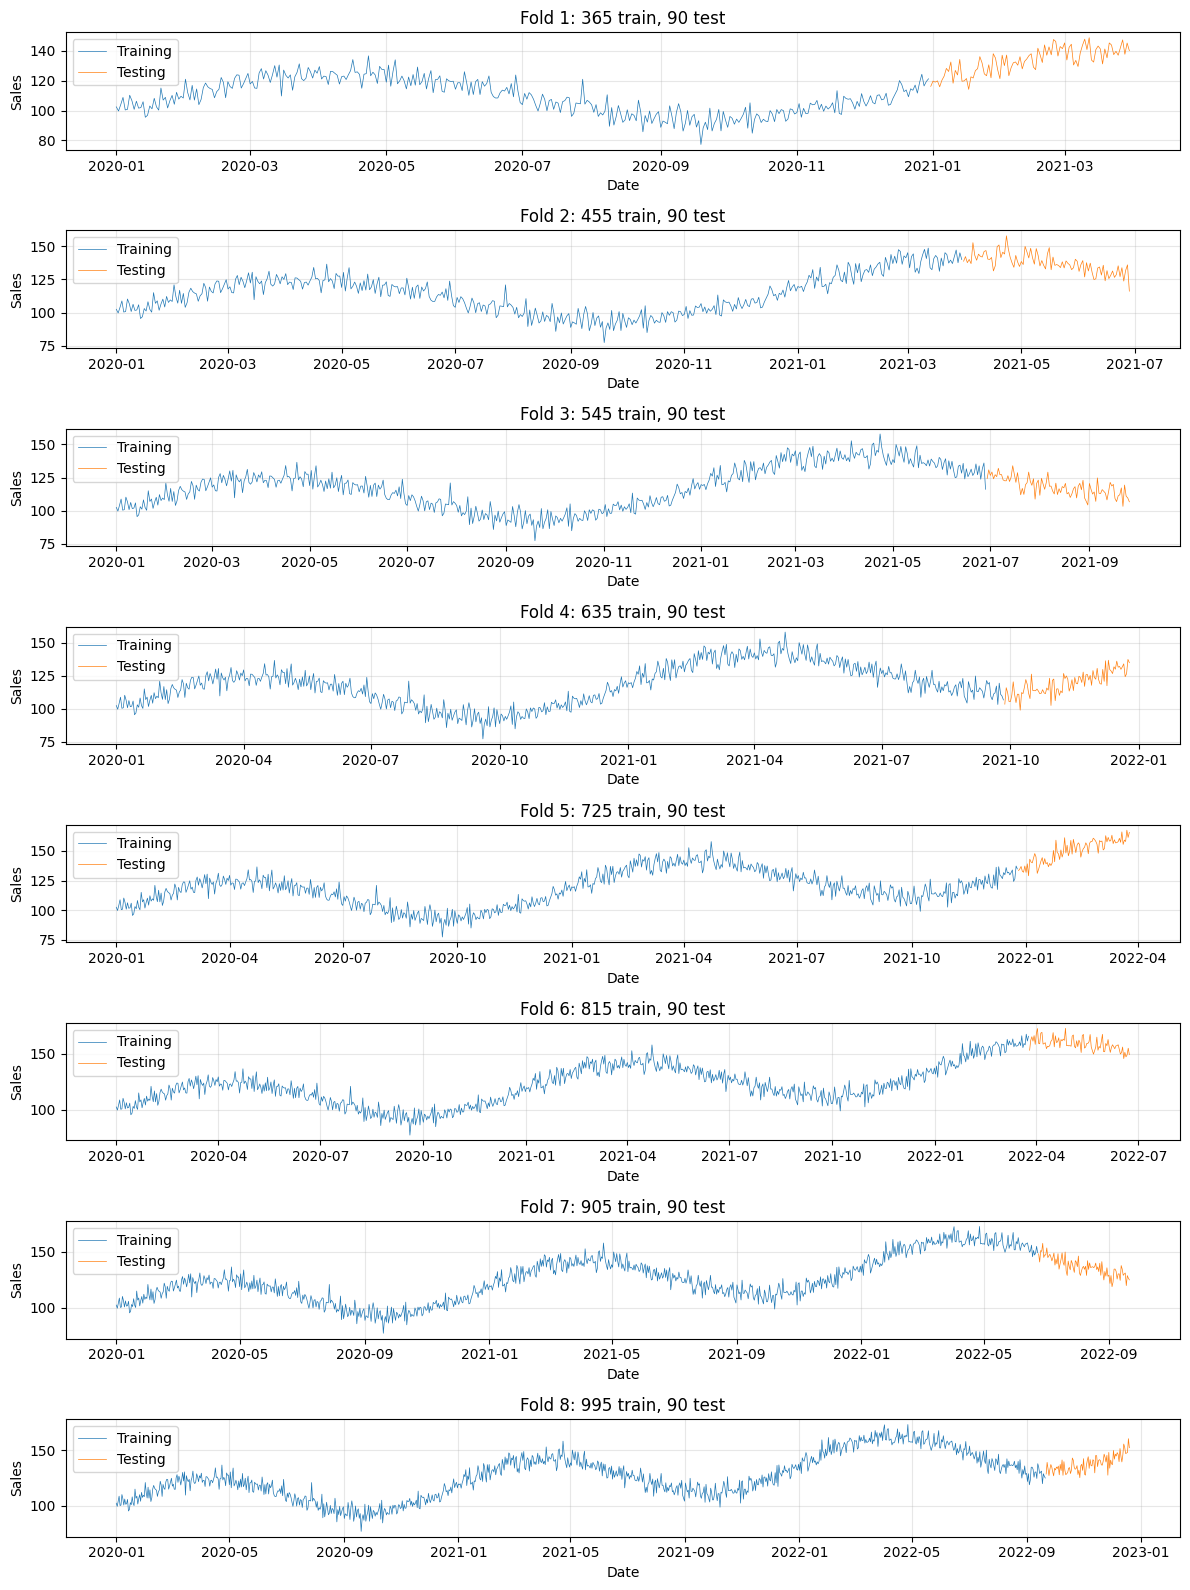

In [33]:
# Visualize expanding window CV
fig, axes = plt.subplots(len(cv_expanding), 1, figsize=(12, 2*len(cv_expanding)))
if len(cv_expanding) == 1:
    axes = [axes]

for i, (fold, ax) in enumerate(zip(cv_expanding, axes), 1):
    train_fold = fold.training()
    test_fold = fold.testing()
    
    ax.plot(train_fold["date"], train_fold["sales"], label="Training", linewidth=0.5)
    ax.plot(test_fold["date"], test_fold["sales"], label="Testing", linewidth=0.5)
    ax.set_title(f"Fold {i}: {len(train_fold)} train, {len(test_fold)} test")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Rolling Window (Sliding)

In a rolling window, both training and test sets slide forward, keeping the training set size constant.

In [34]:
# Create rolling window CV
cv_rolling = time_series_cv(
    data=data,
    date_column="date",
    initial="1 year",      # Fixed 1 year training window
    assess="3 months",     # Each test set is 3 months
    cumulative=False       # Rolling window (fixed size)
)

print(f"Number of CV folds: {len(cv_rolling)}")
print(f"\nFold sizes:")
for i, fold in enumerate(cv_rolling, 1):
    train_fold = fold.training()
    test_fold = fold.testing()
    print(f"Fold {i}: {len(train_fold):4d} train, {len(test_fold):3d} test | "
          f"Train: {train_fold['date'].min()} to {train_fold['date'].max()} | "
          f"Test: {test_fold['date'].min()} to {test_fold['date'].max()}")

Number of CV folds: 8

Fold sizes:
Fold 1:  365 train,  90 test | Train: 2020-01-01 00:00:00 to 2020-12-30 00:00:00 | Test: 2020-12-31 00:00:00 to 2021-03-30 00:00:00
Fold 2:  365 train,  90 test | Train: 2020-03-31 00:00:00 to 2021-03-30 00:00:00 | Test: 2021-03-31 00:00:00 to 2021-06-28 00:00:00
Fold 3:  365 train,  90 test | Train: 2020-06-29 00:00:00 to 2021-06-28 00:00:00 | Test: 2021-06-29 00:00:00 to 2021-09-26 00:00:00
Fold 4:  365 train,  90 test | Train: 2020-09-27 00:00:00 to 2021-09-26 00:00:00 | Test: 2021-09-27 00:00:00 to 2021-12-25 00:00:00
Fold 5:  365 train,  90 test | Train: 2020-12-26 00:00:00 to 2021-12-25 00:00:00 | Test: 2021-12-26 00:00:00 to 2022-03-25 00:00:00
Fold 6:  365 train,  90 test | Train: 2021-03-26 00:00:00 to 2022-03-25 00:00:00 | Test: 2022-03-26 00:00:00 to 2022-06-23 00:00:00
Fold 7:  365 train,  90 test | Train: 2021-06-24 00:00:00 to 2022-06-23 00:00:00 | Test: 2022-06-24 00:00:00 to 2022-09-21 00:00:00
Fold 8:  365 train,  90 test | Train: 202

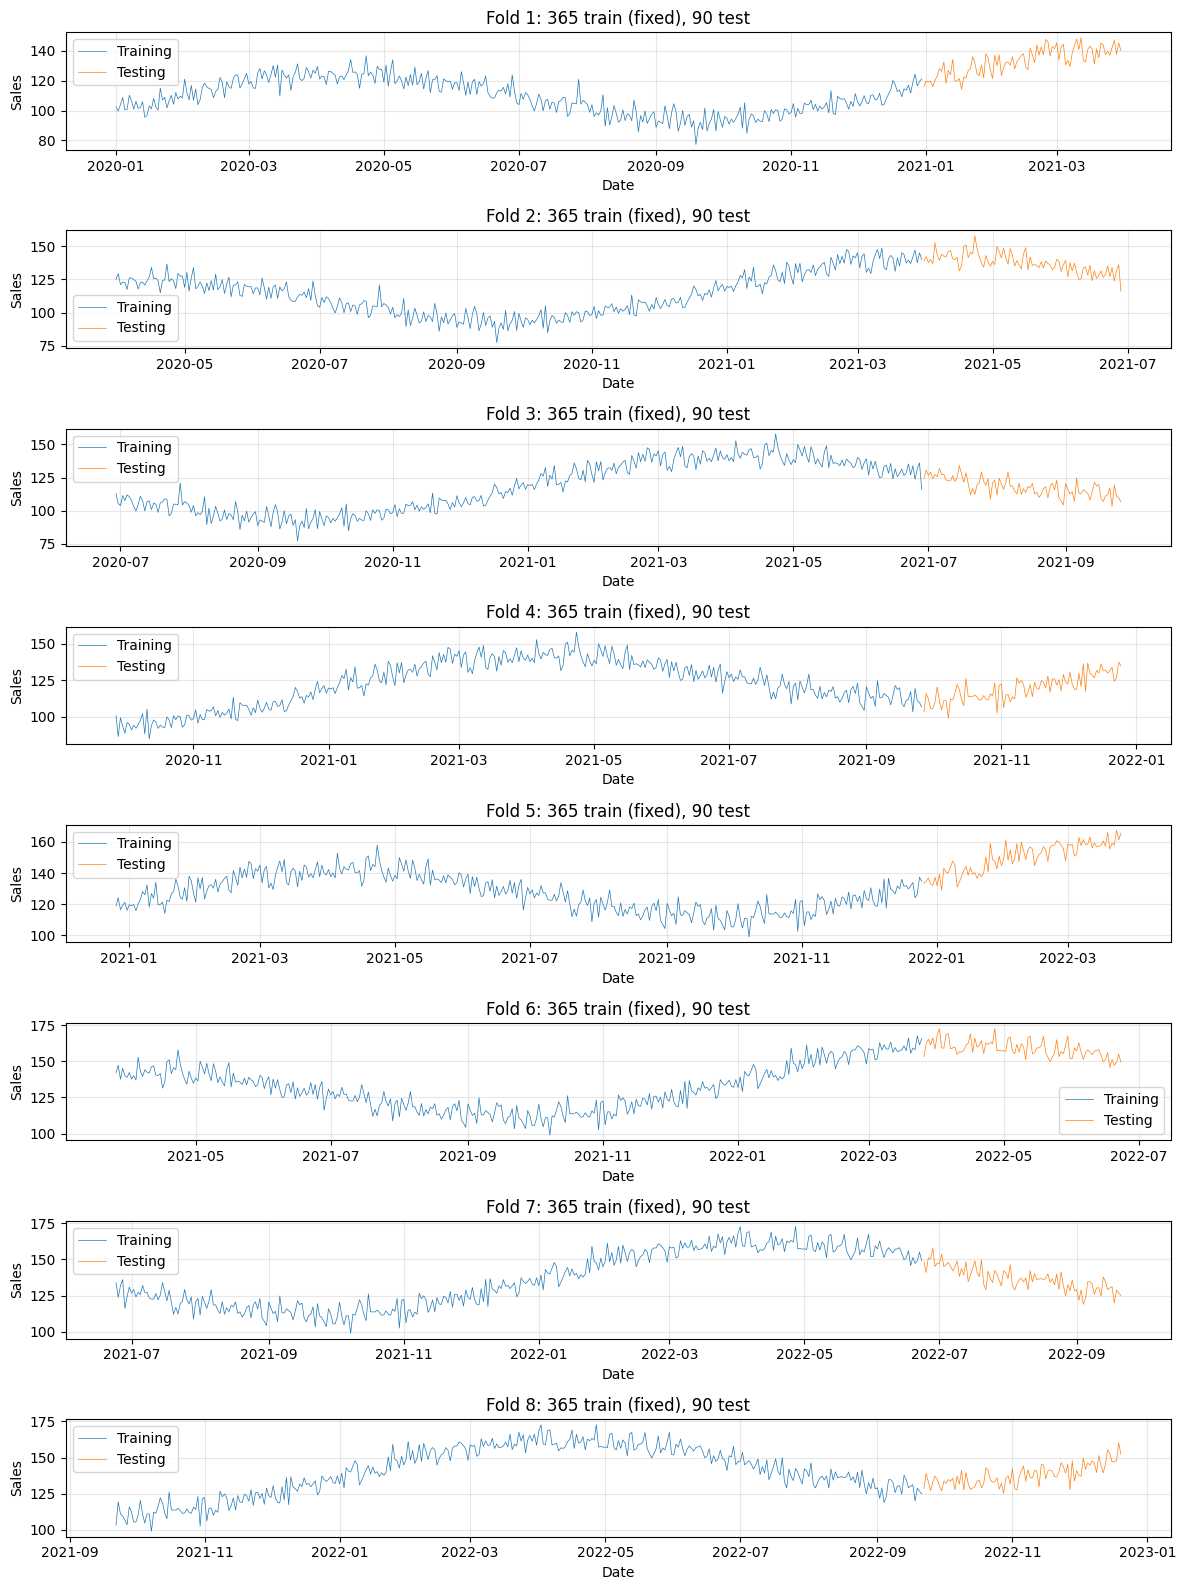

In [35]:
# Visualize rolling window CV
fig, axes = plt.subplots(len(cv_rolling), 1, figsize=(12, 2*len(cv_rolling)))
if len(cv_rolling) == 1:
    axes = [axes]

for i, (fold, ax) in enumerate(zip(cv_rolling, axes), 1):
    train_fold = fold.training()
    test_fold = fold.testing()
    
    ax.plot(train_fold["date"], train_fold["sales"], label="Training", linewidth=0.5)
    ax.plot(test_fold["date"], test_fold["sales"], label="Testing", linewidth=0.5)
    ax.set_title(f"Fold {i}: {len(train_fold)} train (fixed), {len(test_fold)} test")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 CV with Forecast Horizon and Skip

You can add:
- **lag**: Gap between train and test (forecast horizon)
- **skip**: Rows to skip between folds (for less frequent evaluation)

In [36]:
# CV with 7-day forecast horizon, evaluating every 2 months
cv_advanced = time_series_cv(
    data=data,
    date_column="date",
    initial="1 year",
    assess="1 month",
    lag="7 days",          # 7-day forecast horizon
    skip="1 month",        # Skip 1 month between folds
    cumulative=True
)

print(f"Number of CV folds: {len(cv_advanced)}")
print(f"\nFold details:")
for i, fold in enumerate(cv_advanced, 1):
    train_fold = fold.training()
    test_fold = fold.testing()
    
    # Calculate gap
    gap_days = (test_fold["date"].iloc[0] - train_fold["date"].iloc[-1]).days
    
    print(f"Fold {i}: {len(train_fold):4d} train, {len(test_fold):3d} test, {gap_days} day gap")

Number of CV folds: 12

Fold details:
Fold 1:  365 train,  30 test, 8 day gap
Fold 2:  425 train,  30 test, 8 day gap
Fold 3:  485 train,  30 test, 8 day gap
Fold 4:  545 train,  30 test, 8 day gap
Fold 5:  605 train,  30 test, 8 day gap
Fold 6:  665 train,  30 test, 8 day gap
Fold 7:  725 train,  30 test, 8 day gap
Fold 8:  785 train,  30 test, 8 day gap
Fold 9:  845 train,  30 test, 8 day gap
Fold 10:  905 train,  30 test, 8 day gap
Fold 11:  965 train,  30 test, 8 day gap
Fold 12: 1025 train,  30 test, 8 day gap


## 4. Integration with py-parsnip: Model Evaluation

Let's use time series CV to evaluate a linear regression model.

In [37]:
# Create expanding window CV
cv = time_series_cv(
    data=data,
    date_column="date",
    initial="18 months",
    assess="3 months",
    cumulative=True
)

# Define model
spec = linear_reg().set_engine("sklearn")

# Store results
results = []

# Evaluate model on each fold
for i, fold in enumerate(cv, 1):
    # Get train/test data
    train_fold = fold.training()
    test_fold = fold.testing()
    
    # Fit model
    fit = spec.fit(train_fold, "sales ~ year + day_of_year")
    
    # Predict on test set
    preds = fit.predict(test_fold)
    
    # Calculate metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    rmse = np.sqrt(mean_squared_error(test_fold["sales"], preds[".pred"]))
    mae = mean_absolute_error(test_fold["sales"], preds[".pred"])
    r2 = r2_score(test_fold["sales"], preds[".pred"])
    
    results.append({
        "fold": i,
        "train_size": len(train_fold),
        "test_size": len(test_fold),
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    })
    
    print(f"Fold {i}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

print(f"\n{'='*60}")
print(f"Average Performance Across {len(cv)} Folds:")
print(f"  RMSE: {results_df['rmse'].mean():.2f} ± {results_df['rmse'].std():.2f}")
print(f"  MAE:  {results_df['mae'].mean():.2f} ± {results_df['mae'].std():.2f}")
print(f"  R²:   {results_df['r2'].mean():.3f} ± {results_df['r2'].std():.3f}")
print(f"{'='*60}")

Fold 1: RMSE=12.72, MAE=11.25, R²=-2.313
Fold 2: RMSE=9.75, MAE=8.17, R²=-0.335
Fold 3: RMSE=11.12, MAE=9.44, R²=-0.239
Fold 4: RMSE=13.16, MAE=12.22, R²=-5.015
Fold 5: RMSE=11.45, MAE=9.65, R²=-1.018
Fold 6: RMSE=8.46, MAE=7.10, R²=-0.466

Average Performance Across 6 Folds:
  RMSE: 11.11 ± 1.78
  MAE:  9.64 ± 1.89
  R²:   -1.564 ± 1.857


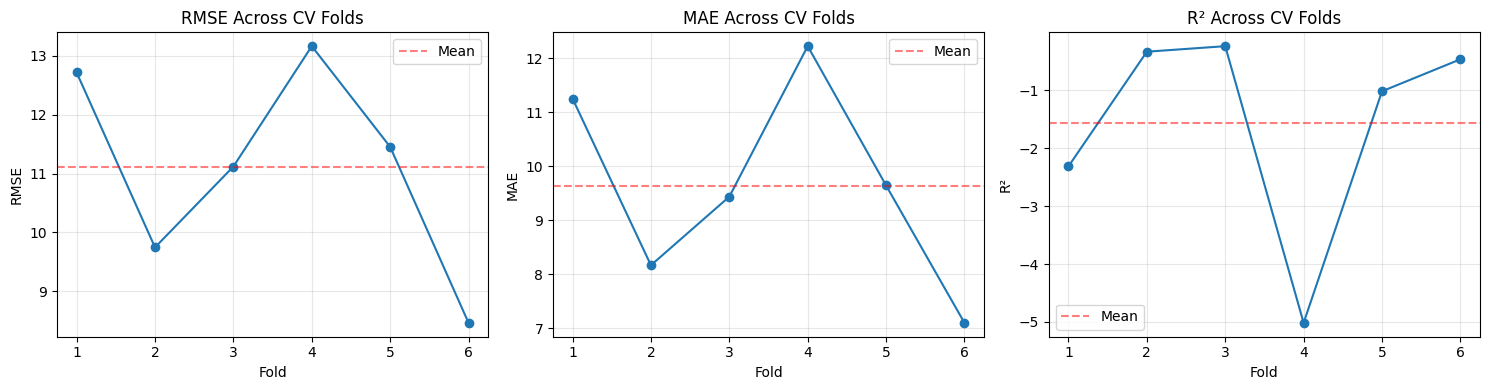

In [38]:
# Visualize performance across folds
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = [("rmse", "RMSE"), ("mae", "MAE"), ("r2", "R²")]
for ax, (metric, label) in zip(axes, metrics):
    ax.plot(results_df["fold"], results_df[metric], marker="o")
    ax.axhline(results_df[metric].mean(), color="red", linestyle="--", alpha=0.5, label="Mean")
    ax.set_xlabel("Fold")
    ax.set_ylabel(label)
    ax.set_title(f"{label} Across CV Folds")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Comparing Rolling vs Expanding Windows

Let's compare model performance using rolling vs expanding windows.

In [39]:
def evaluate_cv(cv, name):
    """Evaluate model using given CV strategy"""
    spec = linear_reg().set_engine("sklearn")
    results = []
    
    for i, fold in enumerate(cv, 1):
        train_fold = fold.training()
        test_fold = fold.testing()
        
        fit = spec.fit(train_fold, "sales ~ year + day_of_year")
        preds = fit.predict(test_fold)
        
        from sklearn.metrics import mean_squared_error, r2_score
        rmse = np.sqrt(mean_squared_error(test_fold["sales"], preds[".pred"]))
        r2 = r2_score(test_fold["sales"], preds[".pred"])
        
        results.append({"fold": i, "rmse": rmse, "r2": r2, "strategy": name})
    
    return pd.DataFrame(results)

# Evaluate both strategies
cv_exp = time_series_cv(data, "date", initial="1 year", assess="3 months", cumulative=True)
cv_roll = time_series_cv(data, "date", initial="1 year", assess="3 months", cumulative=False)

results_exp = evaluate_cv(cv_exp, "Expanding")
results_roll = evaluate_cv(cv_roll, "Rolling")

results_combined = pd.concat([results_exp, results_roll])

# Summary statistics
print("\nPerformance Comparison:")
print("=" * 60)
summary = results_combined.groupby("strategy")[["rmse", "r2"]].agg(["mean", "std"])
print(summary)
print("=" * 60)


Performance Comparison:
                rmse                  r2          
                mean       std      mean       std
strategy                                          
Expanding  12.160011  3.334114 -1.765574  1.569080
Rolling    17.178834  6.721421 -4.801467  4.270688


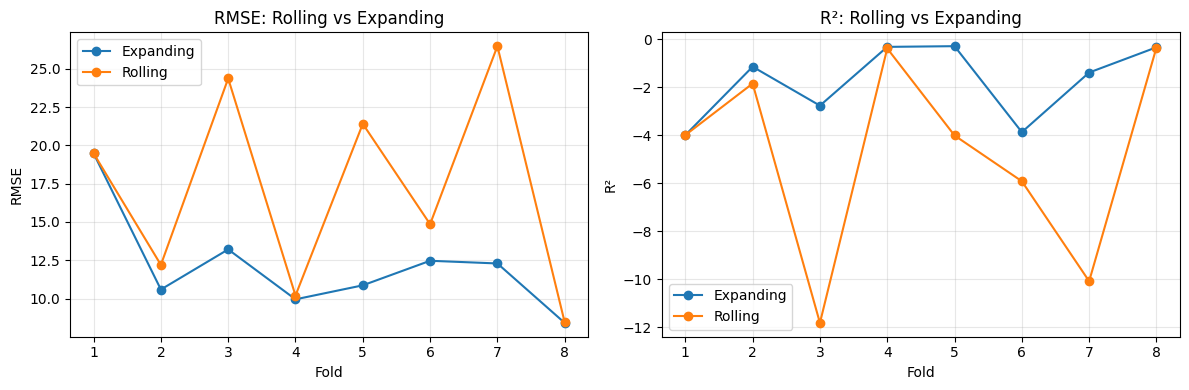

In [40]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RMSE comparison
for strategy in ["Expanding", "Rolling"]:
    data_strat = results_combined[results_combined["strategy"] == strategy]
    axes[0].plot(data_strat["fold"], data_strat["rmse"], marker="o", label=strategy)
axes[0].set_xlabel("Fold")
axes[0].set_ylabel("RMSE")
axes[0].set_title("RMSE: Rolling vs Expanding")
axes[0].legend()
axes[0].grid(alpha=0.3)

# R² comparison
for strategy in ["Expanding", "Rolling"]:
    data_strat = results_combined[results_combined["strategy"] == strategy]
    axes[1].plot(data_strat["fold"], data_strat["r2"], marker="o", label=strategy)
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("R²")
axes[1].set_title("R²: Rolling vs Expanding")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Key Takeaways

### When to Use Each Approach:

**`initial_time_split()`**:
- Simple train/test split for quick model evaluation
- Final model validation before deployment
- When you have plenty of data

**`time_series_cv()` with Expanding Window**:
- More robust performance estimates
- When you want to use all available historical data
- Mimics real-world scenario where training data grows over time
- Better for models that benefit from more data

**`time_series_cv()` with Rolling Window**:
- When recent data is more relevant (concept drift)
- Faster computation (constant training set size)
- When older data may be less relevant
- Better for models sensitive to data age

### Important Considerations:

1. **Forecast Horizon (`lag`)**: Always test with realistic forecast horizons that match your deployment scenario
2. **Test Set Size (`assess`)**: Should be representative of your typical prediction window
3. **Initial Training Size**: Should be large enough to capture patterns (seasonality, trends)
4. **Skip Parameter**: Use to reduce computation when evaluating frequently isn't necessary
5. **Period Strings**: Make your code more readable and maintainable

## 7. Advanced Example: Multi-Model Comparison

Let's compare multiple models using time series CV.

In [41]:
# Define multiple models
models = [
    ("sklearn_default", linear_reg().set_engine("sklearn")),
    ("sklearn_ridge", linear_reg(penalty=0.1, mixture=0.0).set_engine("sklearn")),
    ("statsmodels", linear_reg().set_engine("statsmodels")),
]

# Create CV folds
cv = time_series_cv(
    data=data,
    date_column="date",
    initial="18 months",
    assess="3 months",
    cumulative=True
)

# Evaluate all models
all_results = []

for model_name, spec in models:
    print(f"\nEvaluating {model_name}...")
    
    for i, fold in enumerate(cv, 1):
        train_fold = fold.training()
        test_fold = fold.testing()
        
        fit = spec.fit(train_fold, "sales ~ year + day_of_year")
        preds = fit.predict(test_fold)
        
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        rmse = np.sqrt(mean_squared_error(test_fold["sales"], preds[".pred"]))
        mae = mean_absolute_error(test_fold["sales"], preds[".pred"])
        
        all_results.append({
            "model": model_name,
            "fold": i,
            "rmse": rmse,
            "mae": mae
        })
    
    print(f"  Done ({len(cv)} folds)")

all_results_df = pd.DataFrame(all_results)

# Summary
print("\n" + "="*70)
print("Model Comparison Summary:")
print("="*70)
summary = all_results_df.groupby("model")[["rmse", "mae"]].agg(["mean", "std"])
print(summary)
print("="*70)


Evaluating sklearn_default...
  Done (6 folds)

Evaluating sklearn_ridge...
  Done (6 folds)

Evaluating statsmodels...
  Done (6 folds)

Model Comparison Summary:
                      rmse                 mae          
                      mean       std      mean       std
model                                                   
sklearn_default  11.110020  1.776218  9.638765  1.892736
sklearn_ridge    11.106873  1.774941  9.636030  1.891952
statsmodels      11.110020  1.776218  9.638765  1.892736


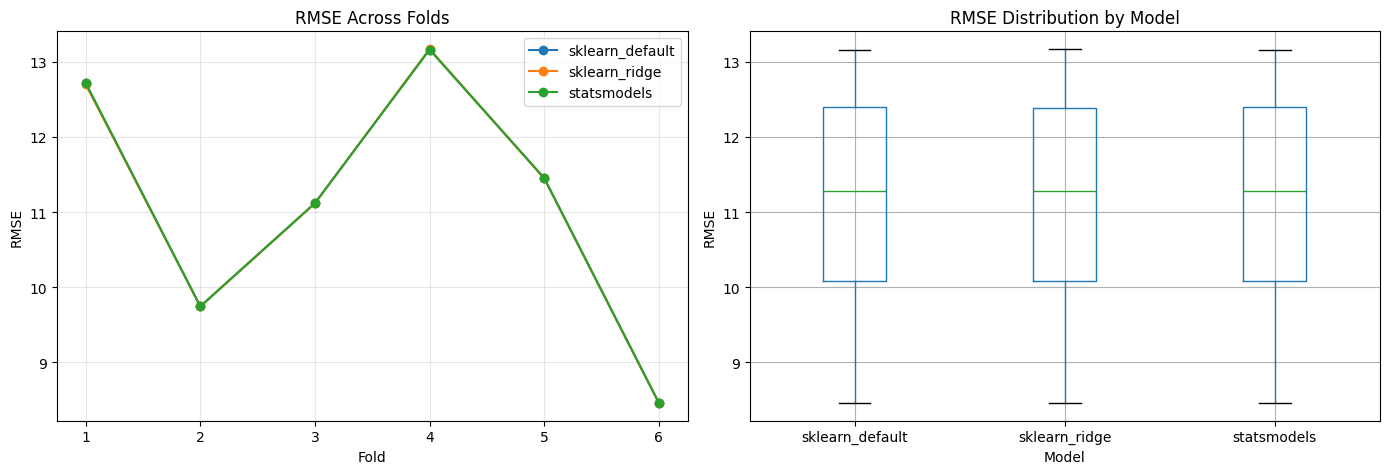

In [42]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
for model in all_results_df["model"].unique():
    data_model = all_results_df[all_results_df["model"] == model]
    axes[0].plot(data_model["fold"], data_model["rmse"], marker="o", label=model)
axes[0].set_xlabel("Fold")
axes[0].set_ylabel("RMSE")
axes[0].set_title("RMSE Across Folds")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot comparison
all_results_df.boxplot(column="rmse", by="model", ax=axes[1])
axes[1].set_xlabel("Model")
axes[1].set_ylabel("RMSE")
axes[1].set_title("RMSE Distribution by Model")
plt.suptitle("")  # Remove automatic title

plt.tight_layout()
plt.show()

## Summary

py-rsample provides powerful tools for time series resampling:

1. **`initial_time_split()`**: Simple chronological train/test splits
2. **`time_series_cv()`**: Robust cross-validation with rolling/expanding windows
3. **Period parsing**: Human-readable time specifications
4. **Forecast horizons**: Realistic gaps between train and test
5. **Integration**: Works seamlessly with py-parsnip models

These tools help you build more robust time series models by properly evaluating them
with temporal ordering respected and realistic forecast scenarios.